# Постановка задачи

Даны точки x и y в файле data_for_regression.csv, необходимо построить модель зависимости y от x и дать прогноз y, для x, начиная с последнего значения в файле до x = 15.

Импортируем библиотеки

In [1]:
# Анализ
import pandas as pd
import numpy as np
import scipy
import sklearn

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Общие функции
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.metrics import r2_score

# Регрессии
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

from scipy.optimize import curve_fit
from numpy import sin

Читаем данные из файла в датафрейм

In [2]:
path = r"02 Data.csv"
df = pd.read_csv(path);

Заменяем бесконечности большим числом – в данном случае достаточно ±12

In [3]:
df.replace([np.inf, -np.inf], [12, -12], inplace=True)

Проверяем, что замена произошла

In [4]:
df.head()

,x,y
0,0.000000,-12.000000
1,0.025183,-10.149463
2,0.050366,-7.517911
3,0.075549,-5.480920
4,0.100732,-5.882184


Разделяем зависимые и независимые переменные

In [5]:
x = df.drop(['y'], axis=1)
y = df['y']

Используем только значения – данное действие нужно для того, чтобы убрать предупреждение об использованнии новых данных для предсказания

In [6]:
x = x.values
y = y.values

Смотрим на данные и оцениваем возможную регрессию. Понятно, что тут синусоида $z(x)$ вида: 
$$
\begin{cases}
g(x) = ln(x)\\
f(x) = sin(x)\\
z(x) = f(x) + g(x) 
\end{cases}
$$
Получим приемлимое решение линейной регрессией. Возможно полиномиальная сходу получит ответ, если не получится – попробуем правильное решение.

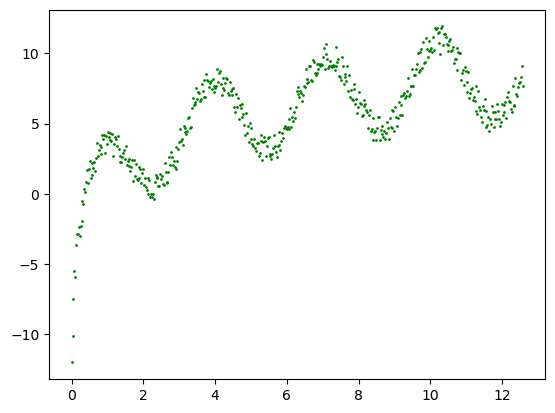

In [7]:
plt.scatter(x, y, color = 'green', s = 1)
plt.show()

Проверяем, что кардинальность множеств равна

In [8]:
print(x.shape, y.shape)

(500, 1) (500,)


Разбиваем выборку на тестовые и обучающие

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)

Добавляем новые данные, по которым хотим получить предсказание

In [10]:
x_new = [13, 13.5, 14, 14.5, 15] # Возможно тут надо генерить значения с тем же шагом, что и в исходном наборе
x_new = np.array(x_new).reshape((-1, 1))

## Линейная регрессия

Начинаем строить регрессионную модель

In [11]:
lr = LinearRegression()

Обучаем модель

In [12]:
lr.fit(x_train, y_train)

LinearRegression()

Проверяем подгонку кросс-валидацией

In [13]:
scores = cross_validate(lr, x_train, y_train, 
                        scoring = ('r2', 'neg_mean_squared_error'),
                        return_train_score = True)

print(f"Время обучения модели: {scores['fit_time']}")
print(f"MSE {scores['test_neg_mean_squared_error']}")
print(f"Коэффициент детерминации {scores['train_r2']}")

Время обучения модели: [0.0021522  0.00101876 0.         0.         0.        ]
MSE [-5.19119756 -4.94051179 -7.20808436 -5.73039681 -8.25622461]
Коэффициент детерминации [0.42617943 0.44673427 0.41821932 0.44504375 0.42105689]


Предсказываем на основе обученной модели

In [14]:
lr_pred = lr.predict(x_test)
lr_pred_train = lr.predict(x_train)

Вычисляем ошибки и коэффициент детерминации

In [15]:
lr_MSE = mean_squared_error(y_test, lr_pred)
lr_MAE = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

Вычисляем y на основе новых данных

In [16]:
lr_y_new = lr.predict(x_new)

Выводим вычисленные значения

In [17]:
lr_y_new

array([ 9.56256168,  9.85763428, 10.15270689, 10.44777949, 10.74285209])

Выводим результаты вычислений

In [18]:
print(f"Константа уравнения линейной регрессии: {lr.intercept_:.3f},\n" 
      f"Коэффициент детерминации R\N{SUPERSCRIPT TWO}: {lr_r2:.3f},\n"
      f"Среднеквадратическая ошибка / Mean squared error / (MSE): {lr_MSE:.3f},\n"
      f"Средняя абсолютная ошибка / Mean absolute error / (MAE): {lr_MAE:.3f}\n"
      f"Коэффициенты {lr.coef_}\n")

Константа уравнения линейной регрессии: 1.891,
Коэффициент детерминации R²: 0.435,
Среднеквадратическая ошибка / Mean squared error / (MSE): 6.587,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 2.127
Коэффициенты [0.5901452]



Выводим графики

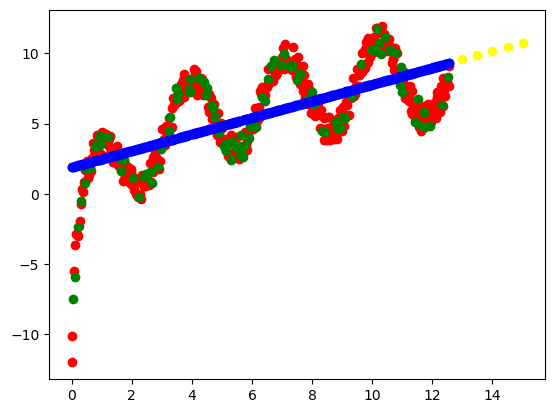

In [19]:
plt.scatter(x_train, y_train, color = 'red')
plt.scatter(x_test, y_test, color = 'green')
plt.scatter(x_train, lr_pred_train, color = 'blue')
plt.scatter(x_new, lr_y_new, color = 'yellow')
plt.show()

Очевидно, что линейная модель очень приближенно описывает с большими остатками. Пробуем другой вариант

## DecisionTreeRegressor

Начинаем строить регрессионную модель

Максимальная глубина дерева = 2
Коэффициент детерминации R²: 0.687,
Среднеквадратическая ошибка / Mean squared error / (MSE): 3.646,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 1.650

Вычисленные значения y = [7.62942038 7.62942038 7.62942038 7.62942038 7.62942038]


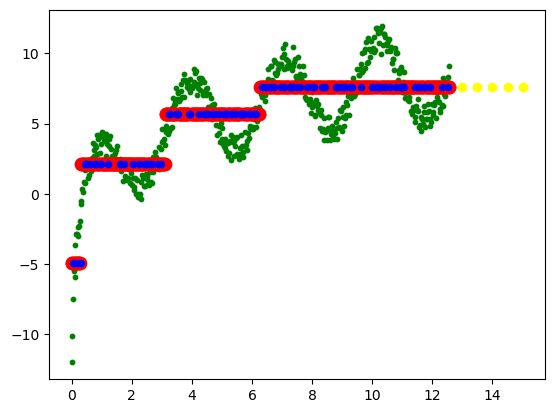

Максимальная глубина дерева = 3
Коэффициент детерминации R²: 0.789,
Среднеквадратическая ошибка / Mean squared error / (MSE): 2.460,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 1.248

Вычисленные значения y = [6.3551334 6.3551334 6.3551334 6.3551334 6.3551334]


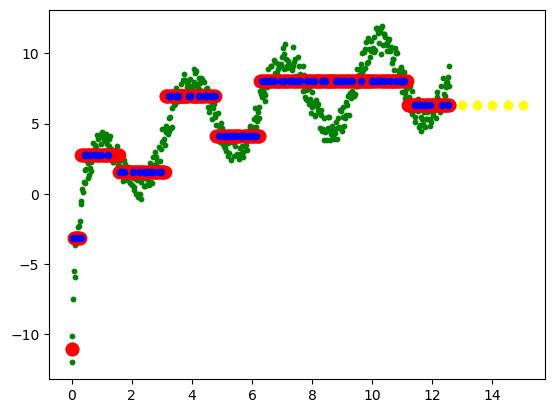

Максимальная глубина дерева = 4
Коэффициент детерминации R²: 0.882,
Среднеквадратическая ошибка / Mean squared error / (MSE): 1.371,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 0.900

Вычисленные значения y = [7.66376139 7.66376139 7.66376139 7.66376139 7.66376139]


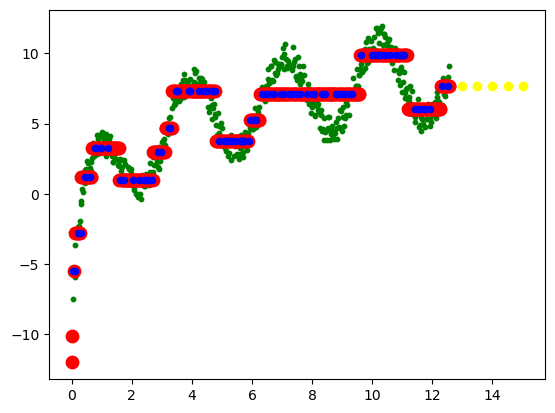

Максимальная глубина дерева = 5
Коэффициент детерминации R²: 0.945,
Среднеквадратическая ошибка / Mean squared error / (MSE): 0.641,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 0.645

Вычисленные значения y = [8.17778696 8.17778696 8.17778696 8.17778696 8.17778696]


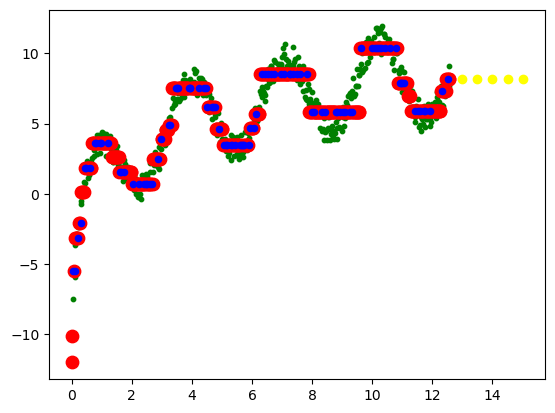

Максимальная глубина дерева = 6
Коэффициент детерминации R²: 0.956,
Среднеквадратическая ошибка / Mean squared error / (MSE): 0.513,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 0.582

Вычисленные значения y = [7.70340131 7.70340131 7.70340131 7.70340131 7.70340131]


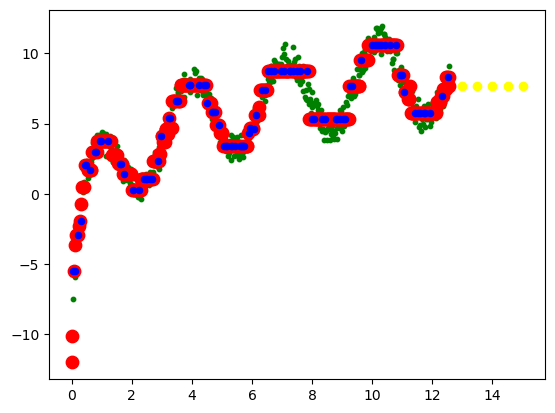

Максимальная глубина дерева = 7
Коэффициент детерминации R²: 0.960,
Среднеквадратическая ошибка / Mean squared error / (MSE): 0.464,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 0.544

Вычисленные значения y = [7.70340131 7.70340131 7.70340131 7.70340131 7.70340131]


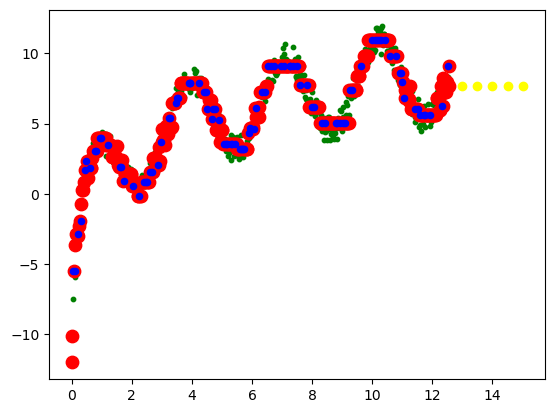

In [20]:
for depth in [2, 3, 4, 5, 6, 7]:
    print(f"Максимальная глубина дерева = {depth}")
    dtr = DecisionTreeRegressor(max_depth = depth)
    # Обучаем модель
    dtr.fit(x_train, y_train)
    # Предсказываем на основе обученной модели
    dtr_pred = dtr.predict(x_test)
    dtr_pred_train = dtr.predict(x_train)
    # Вычисляем ошибки и коэффициент детерминации
    dtr_MSE = mean_squared_error(y_test, dtr_pred)
    dtr_MAE = mean_absolute_error(y_test, dtr_pred)
    dtr_r2 = r2_score(y_test, dtr_pred) # Тут надо уточнить - для этой регрессии используются другие метрики
    # Выводим результаты вычислений
    print(f"Коэффициент детерминации R\N{SUPERSCRIPT TWO}: {dtr_r2:.3f},\n"
      f"Среднеквадратическая ошибка / Mean squared error / (MSE): {dtr_MSE:.3f},\n"
      f"Средняя абсолютная ошибка / Mean absolute error / (MAE): {dtr_MAE:.3f}\n")
    # Вычисляем y на основе новых данных
    dtr_y_new = dtr.predict(x_new)
    print(f"Вычисленные значения y = {dtr_y_new}")
    # Выводим графики
    plt.scatter(x, y, color = 'green', s = 10) # Генеральная совокупность
    plt.scatter(x_train, dtr_pred_train, color = 'red', s = 80) # Обучающая выборка
    plt.scatter(x_test, dtr_pred, color = 'blue', s = 20) # Тестовая выборка
    plt.scatter(x_new, dtr_y_new, color = 'yellow') # Предсказанные значения
    plt.show()

Все еще не то.

## Random Forest Regressor

In [21]:
rfr = RandomForestRegressor()

In [22]:
rfr.fit(x_train, y_train)

RandomForestRegressor()

In [23]:
rfr_pred = rfr.predict(x_test)
rfr_pred_train = rfr.predict(x_train)
rfr_y_new = rfr.predict(x_new)

In [24]:
rfr_MSE = mean_squared_error(y_test, rfr_pred)
rfr_MAE = mean_absolute_error(y_test, rfr_pred)
rfr_r2 = r2_score(y_test, rfr_pred)

In [25]:
print(f"Коэффициент детерминации R\N{SUPERSCRIPT TWO}: {rfr_r2:.3f},\n"
    f"Среднеквадратическая ошибка / Mean squared error / (MSE): {rfr_MSE:.3f},\n"
    f"Средняя абсолютная ошибка / Mean absolute error / (MAE): {rfr_MAE:.3f}\n")

Коэффициент детерминации R²: 0.963,
Среднеквадратическая ошибка / Mean squared error / (MSE): 0.428,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 0.536



In [26]:
rfr_y_new

array([7.99213785, 7.99213785, 7.99213785, 7.99213785, 7.99213785])

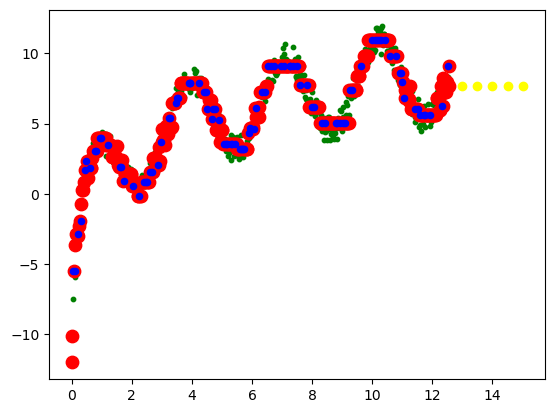

In [27]:
plt.scatter(x, y, color = 'green', s = 10) # Генеральная совокупность
plt.scatter(x_train, dtr_pred_train, color = 'red', s = 80) # Обучающая выборка
plt.scatter(x_test, dtr_pred, color = 'blue', s = 20) # Тестовая выборка
plt.scatter(x_new, dtr_y_new, color = 'yellow') # Предсказанные значения
plt.show()

Не то

## Полиномиальная регрессия

Степень полинома = 2
Константа уравнения линейной регрессии: -0.917,
Коэффициент детерминации R²: 0.502,
Среднеквадратическая ошибка / Mean squared error / (MSE): 5.225,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 2.008
Корень средней квадратичной ошибки / Root Mean Squared Error / (RMSE): 2.286
Коэффициенты [ 1.87338754 -0.09991733]

[6.55069732 6.16348647 5.72631696 5.23918878 4.70210194]


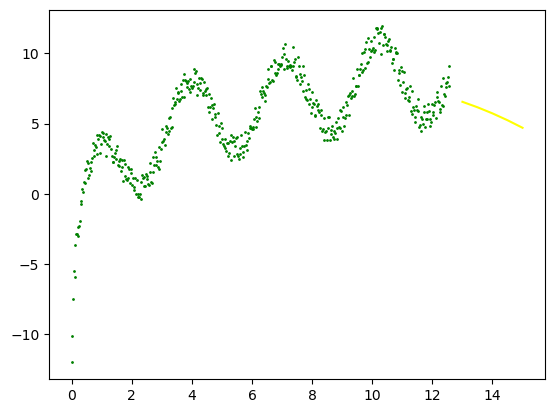

Степень полинома = 3
Константа уравнения линейной регрессии: -1.195,
Коэффициент детерминации R²: 0.503,
Среднеквадратическая ошибка / Mean squared error / (MSE): 5.217,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 2.013
Корень средней квадратичной ошибки / Root Mean Squared Error / (RMSE): 2.284
Коэффициенты [ 2.13018308 -0.15006234  0.00262482]

[6.90379723 6.67187485 6.41807391 6.14436303 5.85271082]


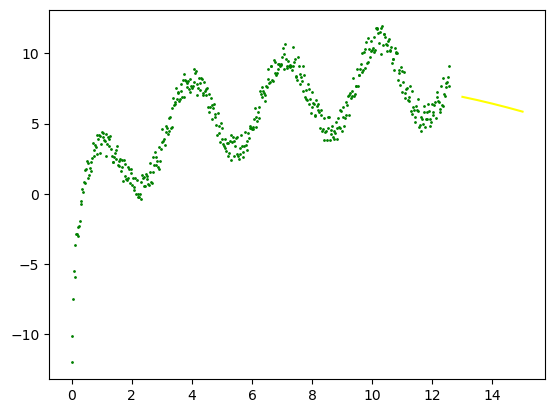

Степень полинома = 4
Константа уравнения линейной регрессии: -2.621,
Коэффициент детерминации R²: 0.531,
Среднеквадратическая ошибка / Mean squared error / (MSE): 4.924,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 1.980
Корень средней квадратичной ошибки / Root Mean Squared Error / (RMSE): 2.219
Коэффициенты [ 4.36684940e+00 -9.49523975e-01  1.01160033e-01 -3.89838888e-03]

[ 4.58480363  2.68671386  0.23042136 -2.8690124  -6.70237351]


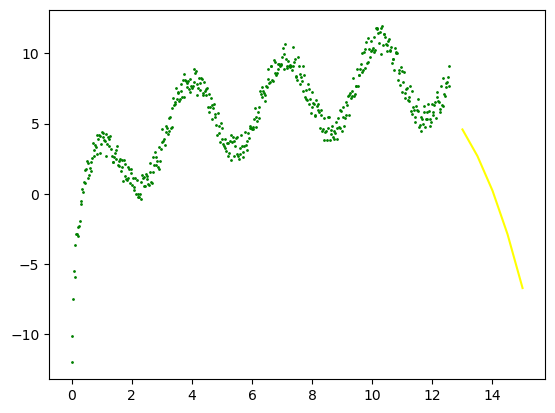

Степень полинома = 5
Константа уравнения линейной регрессии: -2.724,
Коэффициент детерминации R²: 0.531,
Среднеквадратическая ошибка / Mean squared error / (MSE): 4.922,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 1.980
Корень средней квадратичной ошибки / Root Mean Squared Error / (RMSE): 2.218
Коэффициенты [ 4.61335754e+00 -1.08694506e+00  1.30244887e-01 -6.49225282e-03
  8.22152459e-05]

[ 4.80442424  3.13662346  1.02445371 -1.58558958 -4.74811676]


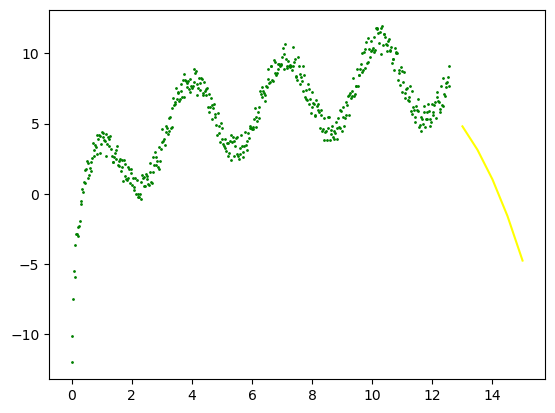

Степень полинома = 6
Константа уравнения линейной регрессии: -3.529,
Коэффициент детерминации R²: 0.537,
Среднеквадратическая ошибка / Mean squared error / (MSE): 4.861,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 1.969
Корень средней квадратичной ошибки / Root Mean Squared Error / (RMSE): 2.205
Коэффициенты [ 7.37498926e+00 -3.29615667e+00  8.34305524e-01 -1.11449868e-01
  7.41772594e-03 -1.94090213e-04]

[  2.45823896  -2.58244847 -10.42786905 -22.10390694 -38.88106164]


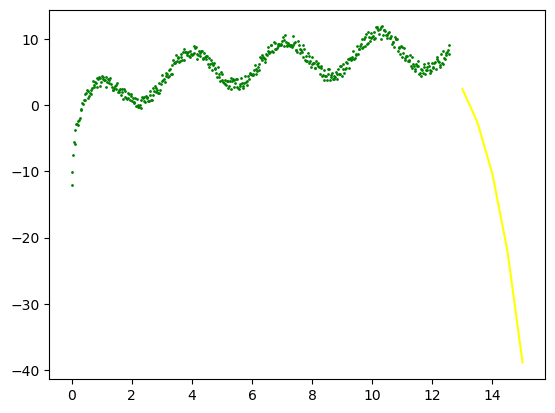

Степень полинома = 7
Константа уравнения линейной регрессии: -7.199,
Коэффициент детерминации R²: 0.579,
Среднеквадратическая ошибка / Mean squared error / (MSE): 4.419,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 1.749
Корень средней квадратичной ошибки / Root Mean Squared Error / (RMSE): 2.102
Коэффициенты [ 2.44459487e+01 -2.17442809e+01  8.99723695e+00 -1.89584684e+00
  2.11482462e-01 -1.18936734e-02  2.65313637e-04]

[ 16.96755404  39.40569625  84.87237987 167.0796816  304.8979999 ]


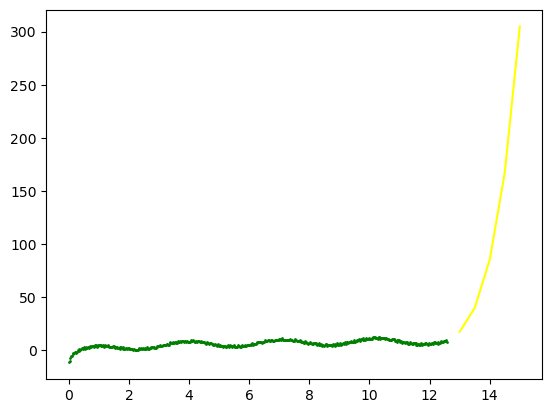

Степень полинома = 8
Константа уравнения линейной регрессии: -7.800,
Коэффициент детерминации R²: 0.585,
Среднеквадратическая ошибка / Mean squared error / (MSE): 4.360,
Средняя абсолютная ошибка / Mean absolute error / (MAE): 1.737
Корень средней квадратичной ошибки / Root Mean Squared Error / (RMSE): 2.088
Коэффициенты [ 2.81444859e+01 -2.69881921e+01  1.20836403e+01 -2.82103198e+00
  3.64943444e-01 -2.61494456e-02  9.59595724e-04 -1.37981198e-05]

[ 13.56288605  27.68030275  54.66642644 100.58094695 172.81945854]


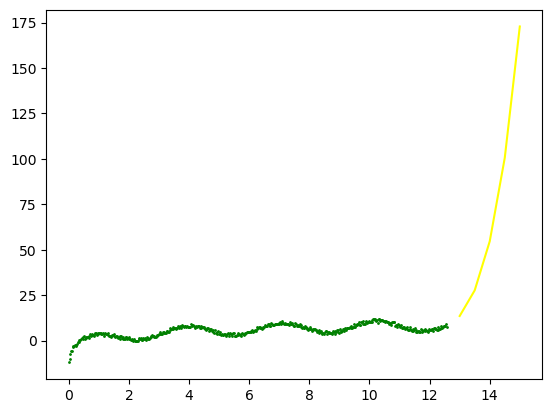

In [28]:
for degree in [2, 3, 4, 5, 6, 7, 8]:
    print(f"Степень полинома = {degree}")
    poly = PolynomialFeatures(degree = degree, include_bias = False)
    # Преобразуем факторы x для дальнейшей работы
    poly_x = poly.fit_transform(x)
    poly_x_train, poly_x_test, poly_y_train, poly_y_test = train_test_split(poly_x, y, test_size=0.3, random_state=101)
    # Подгоняем линейную регрессионную модель
    poly_model = LinearRegression()
    poly_model.fit(poly_x, y)
    poly_model_train = poly_model.fit(poly_x_train, poly_y_train)
    # Вычисляем предсказания
    poly_pred = poly_model.predict(poly_x_test)
    poly_pred_train = poly_model.predict(poly_x_train)
    # Вычисляем ошибки и коэффициент детерминации
    poly_MSE = mean_squared_error(poly_y_test, poly_pred)
    poly_MAE = mean_absolute_error(poly_y_test, poly_pred)
    poly_RMSE = np.sqrt(poly_MSE)
    poly_r2 = r2_score(poly_y_test, poly_pred)
    # Выводим ошибкии и коэффициент детерминации
    print(f"Константа уравнения линейной регрессии: {poly_model.intercept_:.3f},\n" 
      f"Коэффициент детерминации R\N{SUPERSCRIPT TWO}: {poly_r2:.3f},\n"
      f"Среднеквадратическая ошибка / Mean squared error / (MSE): {poly_MSE:.3f},\n"
      f"Средняя абсолютная ошибка / Mean absolute error / (MAE): {poly_MAE:.3f}\n"
      f"Корень средней квадратичной ошибки / Root Mean Squared Error / (RMSE): {poly_RMSE:.3f}\n"
      f"Коэффициенты {poly_model.coef_}\n")
    # Вычисляем предсказания на новых данных
    poly_pred_new = poly_model.predict(poly.fit_transform(x_new))
    # Выводим вычисленные значения
    print(poly_pred_new)
    # Выводим графики
    plt.scatter(x, y, color = 'green', s = 1)
    plt.plot(x_new, poly_pred_new, color = 'yellow')
    plt.show()

Все еще не то. Жаль.

## Подгонка кривых

Обрабатываем исходные данные, чтобы подгонка кривой сработала

In [29]:
y = y.reshape(-1, 1)
x = x.flatten()
y = y.flatten()

In [30]:
def objective(x, a, b, c, d):
    return (a * sin(b * (x - c)) + d)
# a – амплитуда
# b – частота
# c – горизонтальный сдвиг
# d – вертикальный сдвиг

In [31]:
popt, pcov = curve_fit(objective, x, y, bounds=((2, 2, 0.5, 3), (3, 2.5, 1, 6)))

In [32]:
a, b, c, d = popt
print(popt)

[2.40699001 2.14001867 0.52112885 5.60711149]


In [33]:
# TODO: доделать без polyfit
def objective_ln(x, k):
    return (k * np.log(x))

In [34]:
popt_g, pcov_g = np.polyfit(x, y, 1)

In [35]:
k = popt_g
print(popt_g, pcov_g)

0.6011315963486948 1.7972656217413256


C:\Users\ivash\AppData\Local\Temp\ipykernel_18176\15607454.py:3: RuntimeWarning: divide by zero encountered in log
  return (k * np.log(x))


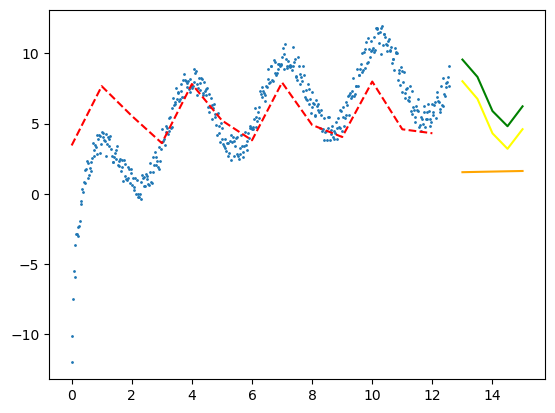

In [36]:
plt.scatter(x, y, s = 1)
x_line = np.arange(min(x), max(x), 1)
y_line_f = objective(x_line, a, b, c, d)
y_line_g = objective_ln(x_line, k)
plt.plot(x_line, y_line_f, '--', color='red')
plt.plot(x_new, objective(x_new, a, b, c, d), color = 'yellow')
plt.plot(x_new, objective_ln(x_new, k), color = 'orange')
plt.plot(x_new, (objective(x_new, a, b, c, d) + objective_ln(x_new, k)), color = 'green')
plt.show()

Больше похоже на правду

Дальнейшие действия сведутся к построению графиков

In [37]:
print(f"Полученные значения f(x): {objective(x_new, a, b, c, d).flatten()} \n"
     f"Полученные значения g(x): {popt_g, pcov_g}"
     )

Полученные значения f(x): [8.01409886 6.75962052 4.30680026 3.2060019  4.60180026] 
Полученные значения g(x): (0.6011315963486948, 1.7972656217413256)


Получили формулу:

$ z(x) = 8.014 * sin(6.76 * (x - 4.307)) + 4.6 + 0.601 * ln(x) + 1.8 $